https://github.com/rmeinl/apricot-julia/blob/5f130f846f8b7f93bb4429e2b182f0765a61035c/notebooks/python_reimpl.ipynb

In [1]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

import time
import scipy
import numpy as np

from numba import njit
from numba import prange
from sklearn.datasets import fetch_covtype

In [2]:
digits_data = fetch_covtype()

In [3]:
X_digits = np.abs(digits_data.data)

In [4]:
def calculate_gains(func, parallel, fastmath, cache):
    @njit(parallel=parallel, fastmath=fastmath, cache=cache)
    def calculate_gains_(X, gains, current_values, idxs, current_concave_values_sum):
        for i in prange(idxs.shape[0]):
            idx = idxs[i]
            gains[i] = func(current_values + X[idx, :]).sum()
        gains -= current_concave_values_sum
        return gains

    return calculate_gains_

In [5]:
def fit(X, k):
    calculate_gains_ = calculate_gains(np.sqrt, True, True, False)
    
    n, d = X.shape

    cost = 0.0

    ranking = []
    total_gains = []

    mask = np.zeros(n)
    current_values = np.zeros(d)
    current_concave_values = np.sqrt(current_values)
    current_concave_values_sum = current_concave_values.sum()

    idxs = np.arange(n)

    gains = np.zeros(idxs.shape[0], dtype='float64')
    while cost < k:
        gains = calculate_gains_(X, gains, current_values, idxs, current_concave_values_sum)

        idx = np.argmax(gains)
        best_idx = idxs[idx]
        curr_cost = 1.
        
        if cost + curr_cost > k:
            break

        cost += curr_cost
        # Calculate gains
        gain = gains[idx] * curr_cost

        # Select next
        current_values += X[best_idx, :]
        current_concave_values = np.sqrt(current_values)
        current_concave_values_sum = current_concave_values.sum()

        ranking.append(best_idx)
        total_gains.append(gain)

        mask[best_idx] = 1
        idxs = np.where(mask == 0)[0]

    return ranking, total_gains

In [6]:
k = 1000

In [7]:
tic = time.time()
ranking0, gains0 = fit(X=X_digits, k=k)
toc0 = time.time() - tic
toc0

15.11655855178833

In [8]:
tic = time.time()
ranking0, gains0 = fit(X=X_digits, k=k)
toc0 = time.time() - tic
toc0

14.258497476577759

In [9]:
tic = time.time()
ranking0, gains0 = fit(X=X_digits, k=k)
toc0 = time.time() - tic
toc0

14.307149648666382

In [10]:
tic = time.time()
idxs = np.random.choice(X_digits.shape[0], replace=False, size=k)
X_subset = X_digits[idxs]
gains1 = np.cumsum(X_subset, axis=0)
gains1 = np.sqrt(gains1).sum(axis=1)
toc1 = time.time() - tic
toc1

0.011968374252319336

In [11]:
tic = time.time()
idxs = np.random.choice(X_digits.shape[0], replace=False, size=k)
X_subset = X_digits[idxs]
gains1 = np.cumsum(X_subset, axis=0)
gains1 = np.sqrt(gains1).sum(axis=1)
toc1 = time.time() - tic
toc1

0.01396322250366211

In [12]:
tic = time.time()
idxs = np.random.choice(X_digits.shape[0], replace=False, size=k)
X_subset = X_digits[idxs]
gains1 = np.cumsum(X_subset, axis=0)
gains1 = np.sqrt(gains1).sum(axis=1)
toc1 = time.time() - tic
toc1

0.014959096908569336

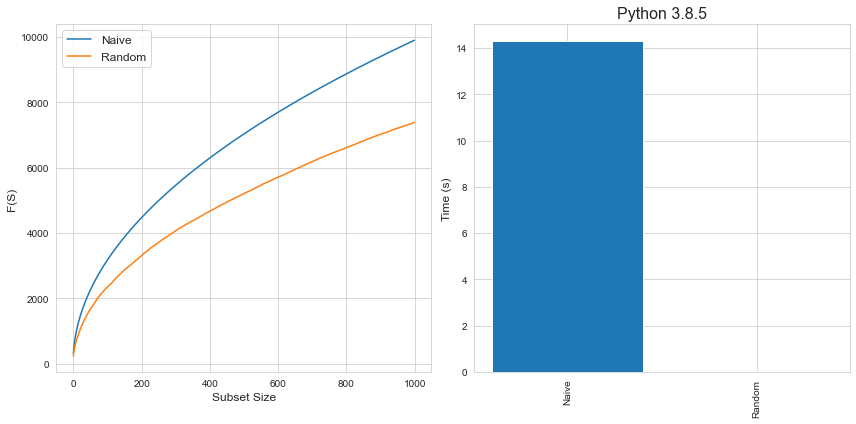

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(np.cumsum(gains0), label="Naive")
plt.plot(gains1, label="Random")
plt.ylabel("F(S)", fontsize=12)
plt.xlabel("Subset Size", fontsize=12)
plt.legend(fontsize=12)

plt.subplot(122)
plt.bar(range(2), [toc0,  toc1])
plt.ylabel("Time (s)", fontsize=12)
plt.xticks(range(2), ['Naive', 'Random'], rotation=90)
plt.title("Python 3.8.5", fontsize=16)

plt.tight_layout()
plt.show()